In [53]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import json
import folium

# supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Data Ingestion, data cleaning & data validation

For this project challenge, 3 datatsets from ECI website have been made available for analysis
- `constituency_wise_results_2014.csv`
- `constituency_wise_results_2019.csv`
- `dim_states_codes.csv`

In [54]:
# import data
df_r14 = pd.read_csv(r"datasets/constituency_wise_results_2014.csv")
df_r19 = pd.read_csv(r"datasets/constituency_wise_results_2019.csv")
states = pd.read_csv(r"datasets/dim_states_codes.csv")

In [55]:
# check few rows from 2014 results dataset
df_r14.head(3)

,state,pc_name,candidate,sex,age,category,party,party_symbol,general_votes,postal_votes,total_votes,total_electors
0,Andhra Pradesh,Adilabad,GODAM NAGESH,M,49.0,ST,TRS,Car,425762,5085,430847,1386282
1,Andhra Pradesh,Adilabad,NARESH,M,37.0,ST,INC,Hand,257994,1563,259557,1386282
2,Andhra Pradesh,Adilabad,RAMESH RATHOD,M,48.0,ST,TDP,Bicycle,182879,1319,184198,1386282


In [56]:
# check few rows from 2019 results dataset
df_r19.head(3)

,state,pc_name,candidate,sex,age,category,party,party_symbol,general_votes,postal_votes,total_votes,total_electors
0,Andhra Pradesh,Aruku,KISHORE CHANDRA DEO,MALE,72.0,ST,TDP,Bicycle,336163,1938,338101,1451418
1,Andhra Pradesh,Aruku,Dr. KOSURI KASI VISWANADHA VEERA VENKATA SATYA...,MALE,54.0,ST,BJP,Lotus,17578,289,17867,1451418
2,Andhra Pradesh,Aruku,GODDETI. MADHAVI,FEMALE,26.0,ST,YSRCP,Ceiling Fan,557561,4629,562190,1451418


In [57]:
# check few rows from dim_states dataset
states.head(3)

,state_name,abbreviation
0,Andaman & Nicobar Islands,AN
1,Andhra Pradesh,AP
2,Arunachal Pradesh,AR


In [58]:
# check no of unique states in both result datasets
df_r14.state.nunique(), df_r19.state.nunique()

(33, 36)

In [59]:
# which states are missing in 2014 dataset
[state for state in list(df_r19.state.unique()) if state not in list(df_r14.state.unique())]

['Odisha', 'Chhattisgarh', 'Telangana']

🔍 Observation:
- Data related to constituencies in 'Odisha' and 'Chhattisgarh' is missing in 2014 dataset.

🔑 Note:
- Telangana was bifurcated from AndhraPradesh in 2014.
- Hence, constituencies belonging to Telangana can be mapped using 2019 dataset.

In [60]:
# get the list of constituencies belonging to telangana state from 2019 dataset
pc_telangana = df_r19[df_r19.state == "Telangana"].pc_name.unique()

# map those constituencies to telangana in 2014 dataset
df_r14.state = df_r14.apply(lambda row: row.state.replace(row.state, "Telangana") \
                            if row.pc_name in list(pc_telangana) else row.state,
                            axis=1)

# check pc_names in telangana state from 2014 dataset after mapping
df_r14[df_r14.state == "Telangana"].pc_name.unique()

array(['Adilabad ', 'Peddapalle ', 'Karimnagar ', 'Nizamabad',
       'Zahirabad', 'Medak', 'Malkajgiri', 'Secundrabad', 'Hyderabad',
       'Mahbubnagar', 'Nagarkurnool', 'Nalgonda', 'Bhongir ', 'Warangal',
       'Mahabubabad  ', 'Khammam '], dtype=object)

In [61]:
# check unique constituency names
df_r14.pc_name.unique()

array(['Adilabad ', 'Peddapalle ', 'Karimnagar ', 'Nizamabad',
       'Zahirabad', 'Medak', 'Malkajgiri', 'Secundrabad', 'Hyderabad',
       'CHELVELLA', 'Mahbubnagar', 'Nagarkurnool', 'Nalgonda', 'Bhongir ',
       'Warangal', 'Mahabubabad  ', 'Khammam ', 'Aruku ', 'Srikakulam',
       'Vizianagaram', 'Visakhapatnam', 'Anakapalli', 'Kakinada',
       'Amalapuram ', 'Rajahmundry', 'Narsapuram', 'Eluru ',
       'Machilipatnam ', 'Vijayawada', 'Guntur', 'Narasaraopet',
       'Bapatla ', 'Ongole ', 'Nandyal', 'Kurnool', 'Anantapur',
       'Hindupur', 'Kadapa', 'Nellore', 'Tirupati ', 'Rajampet',
       'Chittoor ', 'ARUNACHAL WEST', 'ARUNACHAL EAST', 'Karimganj ',
       'Silchar', 'Autonomous District', 'Dhubri', 'Kokrajhar', 'Barpeta',
       'Gauhati', 'Mangaldoi', 'Tezpur', 'Nowgong', 'Kaliabor', 'Jorhat',
       'Dibrugarh', 'Lakhimpur', 'Valmiki Nagar', 'Paschim Champaran',
       'Purvi Champaran', 'Sheohar', 'Sitamarhi', 'Madhubani',
       'Jhanjharpur', 'Supaul', 'Araria', 'K

🔍 Obesrvations:
1. There are extra trailing spaces
2. Few reserved constituencies have (SC) mentioned in their name which is not required for our analysis
3. Few pc_names are in title case while rest are in capital case.
4. There is '-' in between few pc_names.

In [62]:
# create a function to clean above mentioned data errors
def clean_data_errors(pc_name):
    """Cleans data errors in constituency names like
        1. Converts to lowercase
        2. Removes "(SC)" keyword which is not required for our analysis
        3. Replaces hyphen "-" with space
        4. Remove extra trailing spaces.

    Args:
        pc_name: [str] constituency name

    Returns:
        [str] cleaned pc_name
    """
    # convert to lower case
    pc_name = pc_name.lower()

    # remove '(sc)' from pc_name
    pc_name = pc_name.replace("(sc)", "")

    # replace '-' with space
    pc_name = pc_name.replace(" - ", " ")
    pc_name = pc_name.replace("-", " ")

    # remove extra trailing spaces
    pc_name = pc_name.strip()

    return pc_name

In [63]:
# pc_name data errors cleaning
df_r14.pc_name = df_r14.pc_name.apply(lambda x: clean_data_errors(x))
df_r19.pc_name = df_r19.pc_name.apply(lambda x: clean_data_errors(x))

In [64]:
# Number of unique constituencies
df_r14.pc_name.nunique(), df_r19.pc_name.nunique()

(508, 540)

🔍 Obesrvations:
- Since we don't have data related to constituencies in 'Odisha' and 'Chhattisgarh', we can observe less number of constituencies in 2014 dataset.

In [65]:
# verify if the pc_names in 2014 dataset are present in 2019 dataset
[i for i in df_r14.pc_name.unique() if i not in df_r19.pc_name.unique()]

['chelvella', 'joynagar', 'burdwan durgapur', 'dadar & nagar haveli']

🔍 Obesrvations:
- These 4 pc_names have spelling mistakes
- Corrections required as
```
{
"chelvella": "chevella",
"joynagar": "jaynagar",
"burdwan durgapur": "bardhaman durgapur",
"dadar & nagar haveli": "dadra and nagar haveli"
}
```

In [66]:
# replace incorrect pc_names with correct spellings
correct_pc_names = {
                    "chelvella": "chevella",
                    "joynagar": "jaynagar",
                    "burdwan durgapur": "bardhaman durgapur",
                    "dadar & nagar haveli": "dadra and nagar haveli"
                    }
df_r14.pc_name.replace(correct_pc_names, inplace=True)

In [67]:
# statistical info from numerical columns
df_r14.describe()

,age,general_votes,postal_votes,total_votes,total_electors
count,7845.000000,8355.000000,8355.000000,8355.000000,8.355000e+03
mean,47.135883,62132.985398,107.407660,62240.393058,1.574132e+06
std,11.902487,140261.650370,436.090305,140535.827087,2.711797e+05
min,25.000000,105.000000,0.000000,105.000000,4.992200e+04
25%,38.000000,1708.000000,0.000000,1708.500000,1.446478e+06
50%,46.000000,4350.000000,1.000000,4354.000000,1.578125e+06
75%,56.000000,14881.000000,13.000000,14886.000000,1.718414e+06
max,93.000000,859973.000000,6792.000000,863358.000000,3.183083e+06


In [68]:
# statistical info from numerical columns
df_r19.describe()

,age,general_votes,postal_votes,total_votes,total_electors
count,8054.000000,8.597000e+03,8597.000000,8.597000e+03,8.597000e+03
mean,47.065185,7.117290e+04,267.469699,7.144037e+04,1.705181e+06
std,12.140434,1.735669e+05,929.319680,1.742342e+05,2.969405e+05
min,24.000000,8.400000e+01,0.000000,8.400000e+01,5.518900e+04
25%,38.000000,1.315000e+03,1.000000,1.317000e+03,1.553385e+06
50%,46.000000,3.341000e+03,4.000000,3.350000e+03,1.703279e+06
75%,56.000000,1.239100e+04,36.000000,1.242100e+04,1.856791e+06
max,90.000000,1.066824e+06,19367.000000,1.068569e+06,3.150313e+06


In [69]:
# check the rows with age less than 25
df_r19[df_r19.age < 25]

,state,pc_name,candidate,sex,age,category,party,party_symbol,general_votes,postal_votes,total_votes,total_electors
5750,Tamil Nadu,tenkasi,PONNUTHAI.G,FEMALE,24.0,SC,IND,Television,2424,3,2427,1492317


🔍 Obesrvations:
- As per constitutional guidelines minimum age of MP applicant should not be less than 25 years as on the date of scrutiny of nomination papers. However, in 2019 election result dataset we find one candidate having age 24 years.

In [70]:
# For our further analysis we will need a column of voter_turnout_ratio
# Constituency-wise voter turnout ratio
df_r14_grouped = df_r14.groupby(["state", "pc_name"]).agg({"total_votes": 'sum', "total_electors": 'max'}).reset_index()
df_r14_grouped["turnout_ratio"] = round(df_r14_grouped.total_votes*100/df_r14_grouped.total_electors, 2)

df_r19_grouped = df_r19.groupby(["state", "pc_name"]).agg({"total_votes": 'sum', "total_electors": 'max'}).reset_index()
df_r19_grouped["turnout_ratio"] = round(df_r19_grouped.total_votes*100/df_r19_grouped.total_electors, 2)

# State-wise voter turnout ratio
df_r14_grouped_states = df_r14_grouped.groupby(["state"]).agg({"total_votes": 'sum', "total_electors": 'sum'}).reset_index()
df_r14_grouped_states["turnout_ratio"] = round(df_r14_grouped_states.total_votes*100/df_r14_grouped_states.total_electors, 2)

df_r19_grouped_states = df_r19_grouped.groupby(["state"]).agg({"total_votes": 'sum', "total_electors": 'sum'}).reset_index()
df_r19_grouped_states["turnout_ratio"] = round(df_r19_grouped_states.total_votes*100/df_r19_grouped_states.total_electors, 2)

In [71]:
# Overall voter turnout_ratio
print("Overall Turnout ratio")
print("\t2014 Loksabha Elections:" ,\
        round(df_r14_grouped.total_votes.sum()*100/df_r14_grouped.total_electors.sum(),2),"%")

print("\t2019 Loksabha Elections:" ,\
        round(df_r19_grouped.total_votes.sum()*100/df_r19_grouped.total_electors.sum(),2),"%")

Overall Turnout ratio
	2014 Loksabha Elections: 66.06 %
	2019 Loksabha Elections: 67.35 %


**Note:** Here, overall turnout ratio in 2014 elections is not reliable because data for 2 states in missing

In [72]:
# No of states/UTs which have lower turnout ratio than overall turnout ratio in 2019
df_r19_grouped_states[df_r19_grouped_states.turnout_ratio < 67.35].shape[0]

13

In [73]:
# list those 13 states/UTs which have lower turnout ratio than overall turnout ratio in 2019
df_r19_grouped_states[df_r19_grouped_states.turnout_ratio < 67.35].sort_values('turnout_ratio')

,state,total_votes,total_electors,turnout_ratio
13,Jammu & Kashmir,3552622,7922538,44.84
4,Bihar,40806661,71216290,57.30
33,Uttar Pradesh,86481398,146134603,59.18
23,NCT OF Delhi,8679012,14327649,60.58
19,Maharashtra,54054245,88676946,60.96
34,Uttarakhand,4842925,7856318,61.64
31,Telangana,18642895,29708615,62.75
22,Mizoram,499621,792464,63.05
10,Gujarat,29081964,45152373,64.41
0,Andaman & Nicobar Islands,207296,318471,65.09


# 2. Primary Questions

### Q 1. List top 5/ bottom 5 constituencies of 2014 and 2019 in terms of voter turnout ratio

In [19]:
# Top 5 constituencies of 2014
df_r14_grouped.sort_values("turnout_ratio", ascending=False).reset_index(drop=True).head()

,state,pc_name,total_votes,total_electors,turnout_ratio
0,Assam,dhubri,1369624,1550166,88.35
1,Nagaland,nagaland,1038910,1182972,87.82
2,West Bengal,tamluk,1337684,1527273,87.59
3,West Bengal,bishnupur,1272070,1466921,86.72
4,Lakshadweep,lakshadweep,43239,49922,86.61


In [20]:
# Bottom 5 constituencies of 2014
df_r14_grouped.sort_values("turnout_ratio", ascending=True).reset_index(drop=True).head()

,state,pc_name,total_votes,total_electors,turnout_ratio
0,Jammu & Kashmir,srinagar,312212,1207230,25.86
1,Jammu & Kashmir,anantnag,375279,1301143,28.84
2,Jammu & Kashmir,baramulla,465992,1190766,39.13
3,Maharashtra,kalyan,824196,1922034,42.88
4,Bihar,patna sahib,882262,1946249,45.33


In [21]:
# Top 5 constituencies of 2019
df_r19_grouped.sort_values("turnout_ratio", ascending=False).reset_index(drop=True).head()

,state,pc_name,total_votes,total_electors,turnout_ratio
0,Assam,dhubri,1685005,1858566,90.66
1,West Bengal,bishnupur,1420648,1627199,87.31
2,Assam,barpeta,1458549,1685149,86.55
3,West Bengal,jalpaiguri,1500922,1735464,86.49
4,Arunachal Pradesh,arunachal east,293781,339788,86.46


In [22]:
# Bottom 5 constituencies of 2019
df_r19_grouped.sort_values("turnout_ratio", ascending=True).reset_index(drop=True).head()

,state,pc_name,total_votes,total_electors,turnout_ratio
0,Jammu & Kashmir,anantnag,124896,1397779,8.94
1,Jammu & Kashmir,srinagar,186832,1294671,14.43
2,Jammu & Kashmir,baramulla,455550,1317738,34.57
3,Telangana,hyderabad,877872,1957931,44.84
4,Maharashtra,kalyan,890313,1965676,45.29


🔍 Obesrvations:
- We observe that constituencies in North-Estern region of India show maximum voter turnout ratio
- While, constituencies in Jammu & Kashmir show  lowest turnout ratio.

### Q 2. List top 5/ bottom 5 states of 2014 and 2019 in terms of voter turnout ratio

In [23]:
# top 5 states 2014
df_r14_grouped_states.sort_values("turnout_ratio", ascending=False).reset_index(drop=True).head()

,state,total_votes,total_electors,turnout_ratio
0,Nagaland,1038910,1182972,87.82
1,Lakshadweep,43239,49922,86.61
2,Tripura,2023829,2388822,84.72
3,Dadra & Nagar Haveli,165286,196597,84.07
4,Sikkim,308967,370770,83.33


In [24]:
# bottom 5 states 2014
df_r14_grouped_states.sort_values("turnout_ratio", ascending=True).reset_index(drop=True).head()

,state,total_votes,total_electors,turnout_ratio
0,Jammu & Kashmir,3566863,7183129,49.66
1,Bihar,35885332,63800160,56.25
2,Uttar Pradesh,81093120,138810557,58.42
3,Maharashtra,48717419,80798823,60.29
4,Madhya Pradesh,29639807,48121301,61.59


In [25]:
# top 5 states 2019
df_r19_grouped_states.sort_values("turnout_ratio", ascending=False).reset_index(drop=True).head()

,state,total_votes,total_electors,turnout_ratio
0,Lakshadweep,47009,55189,85.18
1,Nagaland,1006357,1213777,82.91
2,Manipur,1617330,1959563,82.54
3,Tripura,2153172,2614718,82.35
4,West Bengal,57206976,70001284,81.72


In [26]:
# bottom 5 states 2019
df_r19_grouped_states.sort_values("turnout_ratio", ascending=True).reset_index(drop=True).head()

,state,total_votes,total_electors,turnout_ratio
0,Jammu & Kashmir,3552622,7922538,44.84
1,Bihar,40806661,71216290,57.30
2,Uttar Pradesh,86481398,146134603,59.18
3,NCT OF Delhi,8679012,14327649,60.58
4,Maharashtra,54054245,88676946,60.96


🔍 Obesrvations:
- As like constituencies, North-estern states having overall higher turnout ratio.
- We can also roughly conclude that states/UTs having thin population density have higher turnout ratio and on the other hand densely populated states/UTs have lower turnout ratio across India.

In [27]:
# Lets visualize Voter Turnout ratio over map of India for 2019 data
with open('in.json', encoding="utf8") as file:
    geojsonData = json.load(file)

for i in geojsonData['features']:
    if(i['properties']['name']=='Orissa'):
        i['properties']['name']='Odisha'
    if(i['properties']['name']=='Andaman and Nicobar'):
        i['properties']['name']='Andaman & Nicobar Islands'
    if(i['properties']['name']=='Delhi'):
        i['properties']['name']='NCT OF Delhi'
    if(i['properties']['name']=='Jammu and Kashmir'):
        i['properties']['name']='Jammu & Kashmir'
    if(i['properties']['name']=='Ladakh'):
        i['properties']['name']='Jammu & Kashmir'
    if(i['properties']['name']=='Dādra and Nagar Haveli and Damān and Diu'):
        i['properties']['name']='Dadra & Nagar Haveli'
    if(i['properties']['name']=='Uttaranchal'):
        i['properties']['name']='Uttarakhand'
        
for i in geojsonData['features']:
    i['id'] = i['properties']['name']
    
map_choropleth = folium.Map(location = [23,81], zoom_start = 4.5)

folium.Choropleth(geo_data=geojsonData,
                 data=df_r19_grouped_states,
                 name='CHOROPLETH',
                 key_on='feature.id',
                 columns = ['state', 'turnout_ratio'],
                 fill_color='viridis',
                 fill_opacity=0.75,
                 line_opacity=0.9,
                 legend_name='turnout_ratio',
                 highlight=True).add_to(map_choropleth)

folium.LayerControl().add_to(map_choropleth)
display(map_choropleth)

### Q 3. Which constituencies have elected the same party for 2 consecutive elections, rank them by % of votes to that winning party in 2019

In [28]:
# Step 1: Get the winning parties for each election year
winning_2014 = df_r14.loc[df_r14.groupby('pc_name')['total_votes'].idxmax()]
winning_2014 = winning_2014[['pc_name', 'party', 'total_votes']].rename(columns={'party': 'party_2014', 'total_votes': 'votes_2014'})

winning_2019 = df_r19.loc[df_r19.groupby('pc_name')['total_votes'].idxmax()]
winning_2019 = winning_2019[['pc_name', 'party', 'total_votes']].rename(columns={'party': 'party_2019', 'total_votes': 'votes_2019'})

# Step 2: finding total_votes per constituency
votes_2014 = df_r14.groupby("pc_name").total_votes.sum().rename("pc_total_votes_2014")
winning_2014 = winning_2014.merge(votes_2014, left_on="pc_name", right_on=votes_2014.index)
winning_2014['winner % votes 2014'] = round((winning_2014.votes_2014*100)/winning_2014.pc_total_votes_2014 , 2)

votes_2019 = df_r19.groupby("pc_name").total_votes.sum().rename("pc_total_votes_2019")
winning_2019 = winning_2019.merge(votes_2019, left_on="pc_name", right_on=votes_2019.index)
winning_2019['winner % votes 2019'] = round((winning_2019.votes_2019*100)/winning_2019.pc_total_votes_2019 , 2)

# Step 3: Merge the two DataFrames on 'constituency'
merged = pd.merge(winning_2014, winning_2019, on='pc_name')

# Step 4: Filter to keep only constituencies where the same party won in both elections
same_pc = merged[merged['party_2014'] == merged['party_2019']]
same_pc[["pc_name", "party_2014", "party_2019", "winner % votes 2019"]].sort_values("winner % votes 2019", ascending=False)

,pc_name,party_2014,party_2019,winner % votes 2019
457,surat,BJP,BJP,74.47
354,navsari,BJP,BJP,74.37
490,vadodara,BJP,BJP,72.30
244,kangra,BJP,BJP,72.02
88,bhilwara,BJP,BJP,71.59
...,...,...,...,...
285,ladakh,BJP,BJP,33.94
268,kishanganj,INC,INC,33.32
300,maharajganj,BJP,BJP,33.02
190,hamirpur,BJP,BJP,32.84


🔍 Obesrvations:- There are total 333 constituencies which elected same party consecutively for second time in 2019 Loksabha elections.

### Q 4. Which constituencies have voted for different parties in two elections (list top 10 based on difference (2019-2014) in winner vote percentage in two elections).

In [29]:
# filter pc_names where different parties elected in 2014 and 2019
diff_pc = merged[merged['party_2014'] != merged['party_2019']]

# calculate winner vote share % difference
diff_pc["diff_winner_%_votes"] = diff_pc["winner % votes 2019"] - diff_pc["winner % votes 2014"]

# filter necessary columns and sort on difference in % vote share
cols = ["pc_name", "party_2014", "winner % votes 2014", "party_2019", "winner % votes 2019", "diff_winner_%_votes"]
diff_pc[cols].sort_values("diff_winner_%_votes", ascending=False).head(10).reset_index(drop=True)

C:\Users\abhirav\AppData\Local\Temp\ipykernel_18596\2944617193.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_pc["diff_winner_%_votes"] = diff_pc["winner % votes 2019"] - diff_pc["winner % votes 2014"]


,pc_name,party_2014,winner % votes 2014,party_2019,winner % votes 2019,diff_winner_%_votes
0,alipurduars,AITC,29.62,BJP,54.40,24.78
1,autonomous district,INC,39.23,BJP,61.73,22.50
2,kanniyakumari,BJP,37.64,INC,59.83,22.19
3,puducherry,AINRC,34.57,INC,56.27,21.70
4,bhagalpur,RJD,37.74,JD(U),59.30,21.56
5,sambhal,BJP,34.08,SP,55.60,21.52
6,jhanjharpur,BJP,35.64,JD(U),56.80,21.16
7,chikkballapur,INC,33.63,BJP,53.78,20.15
8,ghazipur,BJP,31.11,BSP,51.20,20.09
9,supaul,INC,34.30,JD(U),53.78,19.48


In [30]:
# Total number of constituencies where different parties were elected
diff_pc.shape[0]

175

In [31]:
diff_pc.party_2019.value_counts().head()

BJP      48
INC      30
DMK      24
YSRCP    14
JD(U)    14
Name: party_2019, dtype: int64

🔍 Obesrvations:
- There are total 175 constituencies which elected different party in 2019 Loksabha elections
- 48 (~27%) of these 175 constituencies preferred to elect BJP 

### Q 5. Top 5 candidates based on margin difference with runners in 2014 and 2019

In [32]:
# create a function to filter top candidates by margin
def get_top_5_candidates_by_margin(df):
    """Gives top 5 candidates by margin.

    Args:
        df: DataFrame of constituency_wise_result dataset

    Returns:
        DataFrame having top 5 candidates by margin
    """
    df["rnk"] = df.groupby("pc_name")["total_votes"].rank(method="max", ascending=False)

    # filter rank 1 candidates
    df_rank_1 = df[df.rnk == 1.0]
    df_rank_1 = df_rank_1[["pc_name", "candidate", "total_votes"]].rename(columns={"total_votes": "rank_1_votes"})

    # filter rank 2 candidates
    df_rank_2 = df[df.rnk == 2.0]
    df_rank_2 = df_rank_2[["pc_name", "total_votes"]].rename(columns={"total_votes": "rank_2_votes"})

    # merge dataframes to get pc_name, candidate, rank_1_votes, rank_2_votes, margin
    df_rank = pd.merge(df_rank_1, df_rank_2, on="pc_name")
    df_rank["margin"] = df_rank.rank_1_votes - df_rank.rank_2_votes

    # create a column of rank_1 votes to rank_2 votes ratio
    df_rank["rank_1/2_vote_ratio"] = round(df_rank.rank_1_votes/df_rank.rank_2_votes, 2)
    df_top_5_by_margin = df_rank.sort_values("margin", ascending=False).reset_index(drop=True).head()

    return df_top_5_by_margin

In [33]:
# Top 5 candidates based on margin with runners in 2014
get_top_5_candidates_by_margin(df_r14)

,pc_name,candidate,rank_1_votes,rank_2_votes,margin,rank_1/2_vote_ratio
0,vadodara,NARENDRA MODI,845464,275336,570128,3.07
1,ghaziabad,VIJAY KUMAR SINGH,758482,191222,567260,3.97
2,navsari,C. R. PATIL,820831,262715,558116,3.12
3,jaipur,RAMCHARAN BOHARA,863358,324013,539345,2.66
4,surat,DARSHANA VIKRAM JARDOSH,718412,185222,533190,3.88


In [34]:
# Top 5 candidates based on margin with runners in 2019
get_top_5_candidates_by_margin(df_r19)

,pc_name,candidate,rank_1_votes,rank_2_votes,margin,rank_1/2_vote_ratio
0,navsari,C. R. Patil,972739,283071,689668,3.44
1,karnal,Sanjay Bhatia,911594,255452,656142,3.57
2,faridabad,KRISHAN PAL,913222,274983,638239,3.32
3,bhilwara,SUBHASH CHANDRA BAHERIA,938160,326160,612000,2.88
4,vadodara,RANJANBEN BHATT,883719,294542,589177,3.00


### Q 6. % split of votes of parties between 2014 vs 2019 at national level

In [35]:
# Top 10 parties with highest vote share % 2014
df_party_total = pd.DataFrame(df_r14.groupby("party")["total_votes"].sum()).reset_index().sort_values("total_votes", ascending=False)
df_party_total["% share_2014"] = round(df_party_total["total_votes"]*100/sum(df_party_total["total_votes"]), 2)
df_party_total.head(10)

,party,total_votes,% share_2014
80,BJP,161047761,30.97
163,INC,96641749,18.58
110,BSP,22434033,4.31
31,AITC,21215661,4.08
385,SP,18632568,3.58
17,ADMK,18111579,3.48
126,CPM,17938138,3.45
164,IND,15888094,3.06
406,TDP,14099230,2.71
428,YSRCP,13995435,2.69


In [36]:
# Top 10 parties with highest vote share % 2019
df_party_total = pd.DataFrame(df_r19.groupby("party")["total_votes"].sum()).reset_index().sort_values("total_votes", ascending=False)
df_party_total["% share_2019"] = round(df_party_total["total_votes"]*100/sum(df_party_total["total_votes"]), 2)
df_party_total.head(10)

,party,total_votes,% share_2019
126,BJP,229076879,37.30
239,INC,119495214,19.46
44,AITC,24929330,4.06
168,BSP,22246501,3.62
241,IND,16583326,2.70
579,SP,15647206,2.55
652,YSRCP,15537006,2.53
200,DMK,14363332,2.34
566,SHS,12858904,2.09
609,TDP,12515345,2.04


In [37]:
# create a function to plot pie chart of % vote split
def plot_top_n_party_vote_share(df, n):
    """Plots a pie-chart of party-wise % vote share.

    Args:
        df: DataFrame of constituency_wise_result dataset
        n: [int] top n parties
    """
    df = df.groupby("party")["total_votes"].sum().sort_values(ascending=False)
    if df.shape[0] > n:
        df_n = df[:n]
        df_others = df[n:]
        df_n.loc["others"] = sum(df_others)
    else:
        df_n = df
    df_n.plot(kind="pie", autopct="%.2f%%", cmap='tab10')

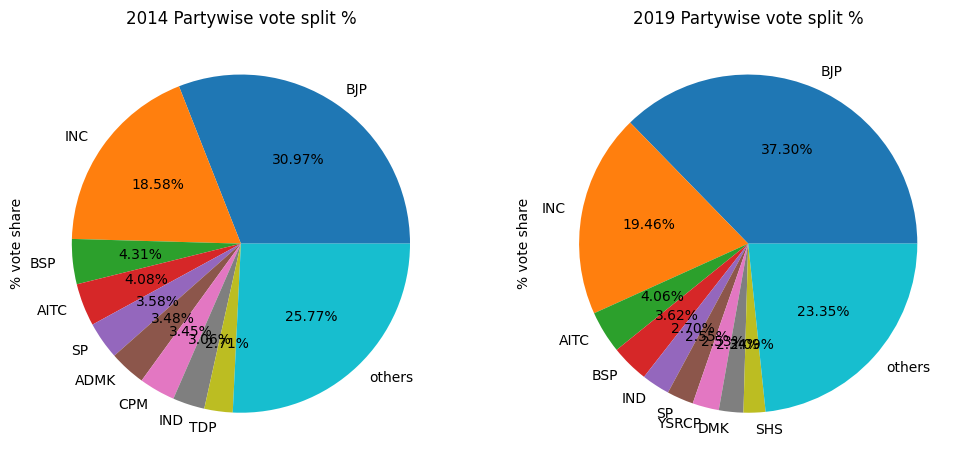

In [38]:
# Plot partywise vote split % in 2014 and 2019
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
plot_top_n_party_vote_share(df_r14, 9)
plt.title("2014 Partywise vote split %")
plt.ylabel("% vote share")

plt.subplot(1,2,2)
plot_top_n_party_vote_share(df_r19, 9)
plt.title("2019 Partywise vote split %")
plt.ylabel("% vote share")
plt.show()

🔍 Obesrvations:
- In both the 2014 and 2019 Loksabha Elections, BJP has massive and maximum vote share in India.
- BJP and INC together constitute almost half of the vote share and hence these are the top 2 major national parties.

### Q 7. % split of votes of parties between 2014 vs 2019 at state level

In [39]:
# Get top 5 states having highest number of constituencies
states_with_max_pc = df_r14.groupby("state")["pc_name"].nunique().sort_values(ascending=False).head()
states_with_max_pc

state
Uttar Pradesh    80
Maharashtra      48
West Bengal      42
Bihar            40
Tamil Nadu       39
Name: pc_name, dtype: int64

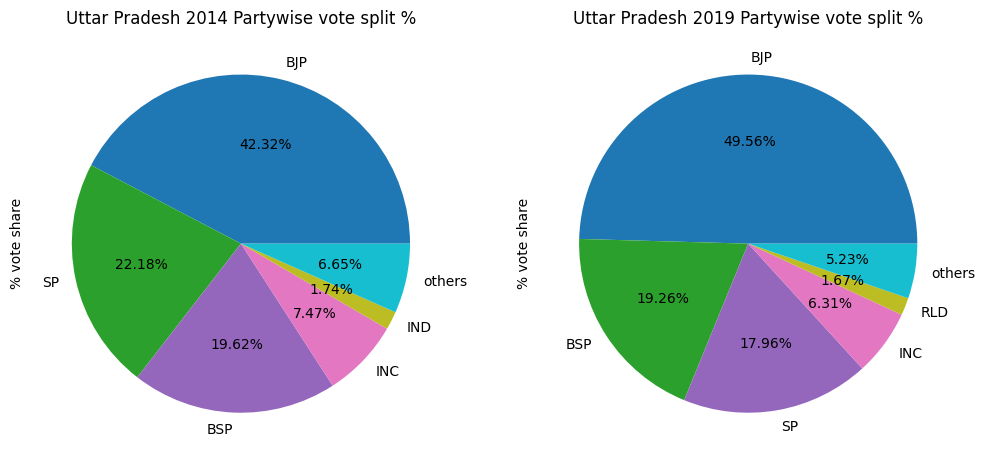

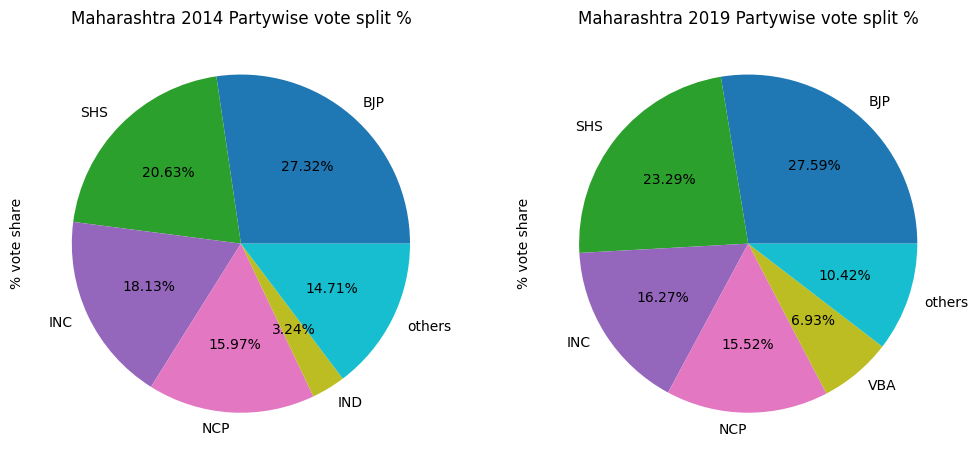

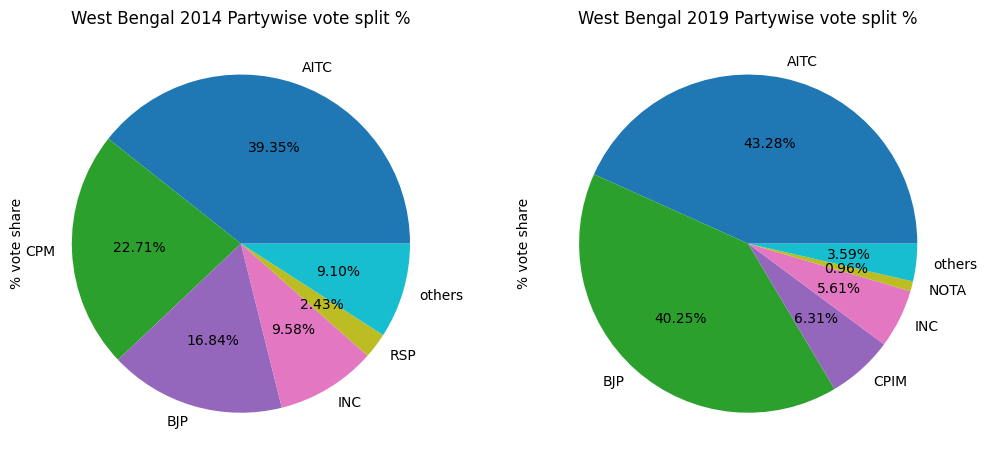

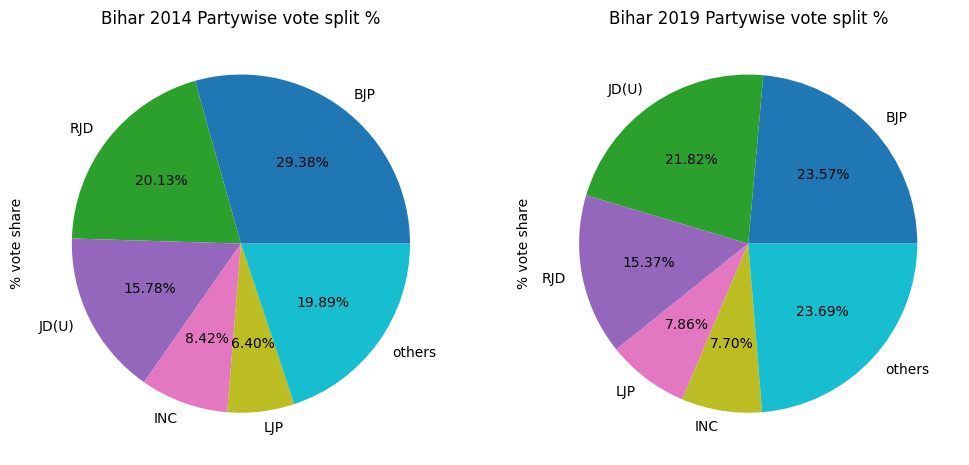

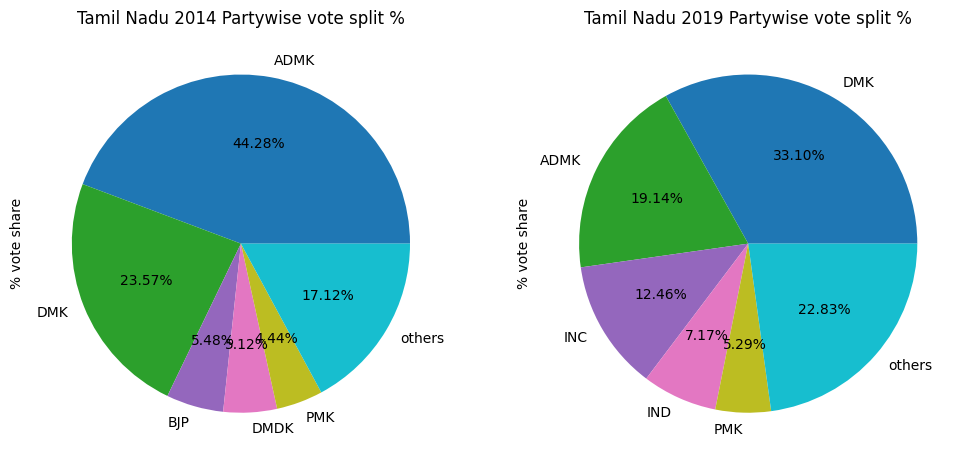

In [40]:
# Plot top 5 parties in each state
for state in states_with_max_pc.index:
    df_14 = df_r14[df_r14.state == state]
    df_19 = df_r19[df_r19.state == state]
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plot_top_n_party_vote_share(df_14, 5)
    plt.title(f"{state} 2014 Partywise vote split %")
    plt.ylabel("% vote share")
    plt.subplot(1,2,2)
    plot_top_n_party_vote_share(df_19, 5)
    plt.title(f"{state} 2019 Partywise vote split %")
    plt.ylabel("% vote share")

### Q 8. List top 5 constituencies for two major national parties where they have gained vote share in 2019 as compared to 2014

Based on national level vote share %, 2 major national parties are
1) Bharatiya Janata Party
2) Indian National Congress


In [41]:
# create a function to filter top 5 constituencies for respective parties based on gain or loss in vote share in 2019
def top_5_pc_gain_loss(party, df_14=df_r14, df_19=df_r19, gain=True):
    """Gives top 5 constituencies based on gain or loss of vote share.

    Args:
        party: [str] party name,
        df_14: [DataFrame] constituency_wise_result_2014 dataset,
        df_15: [DataFrame] constituency_wise_result_2019 dataset,
        gain: [True/False]
            default value = True -> Gives constituencies with gain in vote share
            False -> Gives constituencies with loss in vote share

    Returns:
        DataFrame sorted by % gain/loss in vote share
    """
    # constituency-wise total number of votes
    df_pc_total_14 = df_14.groupby(["state", "pc_name"])["total_votes"].sum()
    df_pc_total_14.rename("pc_total_2014", inplace=True)

    df_pc_total_19 = df_19.groupby(["state", "pc_name"])["total_votes"].sum()
    df_pc_total_19.rename("pc_total_2019", inplace=True)

    # party-wise total number of votes
    df_party_14 = df_14[df_14.party == party][["state", "pc_name", "total_votes"]]
    df_party_14.rename(columns={"total_votes": "votes_2014"}, inplace=True)

    df_party_19 = df_19[df_19.party == party][["state", "pc_name", "total_votes"]]
    df_party_19.rename(columns={"total_votes": "votes_2019"}, inplace=True)

    # merge party-wise and constituency wise results
    df_1 = pd.merge(df_party_14, df_pc_total_14, on=["state", "pc_name"])
    df_2 = pd.merge(df_party_19, df_pc_total_19, on=["state", "pc_name"])

    # merge 2014 and 2019 results together
    df = pd.merge(df_1, df_2, on=["state", "pc_name"])

    # calculate % vote share in each constituency
    df["% votes_14"] = round(df.votes_2014*100/df.pc_total_2014, 2)
    df["% votes_19"] = round(df.votes_2019*100/df.pc_total_2019, 2)

    # calculate gain or loss
    df["% gain/loss"] = df["% votes_19"] - df["% votes_14"]

    # Filter necessary columns
    df = df[["state", "pc_name", "% votes_14", "% votes_19", "% gain/loss"]]

    # return constituencies with gain in vote share if gain = true
    if gain == True:
        return df.sort_values(by="% gain/loss", ascending=False).reset_index(drop=True).head()
        
    # return constituencies with loss in vote share if gain = false
    else:
        return df.sort_values(by="% gain/loss", ascending=True).reset_index(drop=True).head()

In [42]:
# Top 5 constituencies for BJP where they gained vote share % in 2019
top_5_pc_gain_loss("BJP", gain=True)

,state,pc_name,% votes_14,% votes_19,% gain/loss
0,Tripura,tripura west,5.10,51.77,46.67
1,West Bengal,purulia,7.16,49.30,42.14
2,Tripura,tripura east,6.37,46.12,39.75
3,West Bengal,ranaghat,17.27,52.78,35.51
4,West Bengal,jhargram,9.74,44.56,34.82


In [43]:
# Top 5 constituencies for INC where they gained vote share % in 2019
top_5_pc_gain_loss("INC", gain=True)

,state,pc_name,% votes_14,% votes_19,% gain/loss
0,Tamil Nadu,karur,2.91,63.06,60.15
1,Tamil Nadu,tiruchirappalli,5.21,59.28,54.07
2,Tamil Nadu,arani,2.53,54.00,51.47
3,Tamil Nadu,thiruvallur,3.50,54.49,50.99
4,Tamil Nadu,krishnagiri,3.64,52.64,49.00


🔍 Obesrvations:
- BJP has widened its presence in West Bengal and North-estern states on the other hand INC got massive vote gain in South India especially in Tamil Nadu.

### Q 9. List top 5 constituencies for two major national parties where they have lost vote share in 2019 as compared to 2014

In [44]:
# Top 5 constituencies for BJP where they lost vote share % in 2019
top_5_pc_gain_loss("BJP", gain=False)

,state,pc_name,% votes_14,% votes_19,% gain/loss
0,Andhra Pradesh,narsapuram,49.62,1.05,-48.57
1,Andhra Pradesh,visakhapatnam,48.72,2.73,-45.99
2,Andhra Pradesh,tirupati,44.76,1.23,-43.53
3,Maharashtra,sangli,58.43,42.77,-15.66
4,Daman & Diu,daman & diu,53.83,42.98,-10.85


In [45]:
# Top 5 constituencies for INC where they lost vote share % in 2019
top_5_pc_gain_loss("INC", gain=False)

,state,pc_name,% votes_14,% votes_19,% gain/loss
0,Dadra & Nagar Haveli,dadra and nagar haveli,45.12,4.33,-40.79
1,Maharashtra,ratnagiri sindhudurg,38.27,7.02,-31.25
2,Maharashtra,aurangabad,36.51,7.66,-28.85
3,Arunachal Pradesh,arunachal west,38.02,14.22,-23.80
4,West Bengal,raiganj,28.50,6.55,-21.95


🔍 Obesrvations:
- BJP might be lossing its vote share to regional parties in Andhra Pradesh as YSRCP and TDP parties have significantly higher vote share.

### Q 10. Which constituency has voted the most for nota?

In [46]:
# create a function to filter constituencies having highest Nota vote share %
def get_top_5_pc_nota(df):
    """Returns top 5 constituencies where NOTA vote share % is highest.

    Args:
        df: [DataFrame] constituency_wise_result dataset

    Returns:
        Dataframe with top 5 constituencies where NOTA vote share % is highest
    """
    # filter nota votes
    df_nota = df[df.party == "NOTA"]
    
    # group by nota votes by constituency
    df_pc_total = df.groupby(["state", "pc_name"])["total_votes"].sum().rename("pc_total")
    df_nota = df_nota.merge(df_pc_total, on=["state", "pc_name"])
    
    # calculate nota %
    df_nota["nota_vote_%"] = round(df_nota.total_votes*100/df_nota.pc_total, 2)
    df_nota_pct = df_nota[["state", "pc_name", "nota_vote_%"]]
    return df_nota_pct.sort_values(by="nota_vote_%", ascending=False).head().reset_index(drop=True)

In [47]:
# highest nota % constituencies in 2014 
get_top_5_pc_nota(df_r14)

,state,pc_name,nota_vote_%
0,Tamil Nadu,nilgiris,4.99
1,Meghalaya,tura,4.19
2,Gujarat,dahod,3.59
3,Jharkhand,singhbhum,3.40
4,Bihar,samastipur,3.38


In [48]:
# highest nota constituency in 2014 by absolute number of votes
df_nota = df_r14[df_r14.party == "NOTA"]
df_nota[df_nota["total_votes"] == max(df_nota["total_votes"])]

,state,pc_name,candidate,sex,age,category,party,party_symbol,general_votes,postal_votes,total_votes,total_electors,rnk
5416,Tamil Nadu,nilgiris,None of the Above,M,NaN,NaN,NOTA,NOTA,46495,64,46559,1269173,3.0


In [49]:
# highest nota constituencies in 2019
get_top_5_pc_nota(df_r19)

,state,pc_name,nota_vote_%
0,Bihar,gopalganj,5.04
1,Chhattisgarh,bastar,4.56
2,Bihar,paschim champaran,4.51
3,Andhra Pradesh,aruku,4.46
4,Bihar,jamui,4.16


In [50]:
# highest nota constituency in 2019 by absolute number of votes
df_nota = df_r19[df_r19.party == "NOTA"]
df_nota[df_nota["total_votes"] == max(df_nota["total_votes"])]

,state,pc_name,candidate,sex,age,category,party,party_symbol,general_votes,postal_votes,total_votes,total_electors,rnk
798,Bihar,gopalganj,NOTA,NaN,NaN,NaN,NOTA,NaN,51565,95,51660,1839514,3.0


🔍 Observation:
- In 2014 Loksabha Election, `Nilgiris` constituency in Tamil Nadu has voted the most for NOTA, while in 2019, `Gopalganj` constituency in Bihar has voted the most for NOTA in terms of % vote share as well as absolute number of votes.

### Q 11. Which constituencies have elected candidates whose party has less than 10% vote share at state level in 2019?

In [51]:
# Summarize total_votes by state and party
df_state_party = pd.DataFrame(df_r19.groupby(['state', 'party'])['total_votes'].sum()).reset_index()
df_state_party.rename(columns={"total_votes": "party_total_votes"}, inplace=True)

# calculate total_votes per state
df_state = df_r19.groupby("state")["total_votes"].sum().reset_index()
df_state.rename(columns={"total_votes": "state_total_votes"}, inplace=True)

# merge statewise total and partywise total
df_state_party = df_state_party.merge(df_state)

# calculate party share % in state
df_state_party["party_state_%"] = round(df_state_party.party_total_votes*100/df_state_party.state_total_votes, 2)

# merge party share % with constituency wise result dataframe
df_r19_party_state_pct = pd.merge(df_r19, df_state_party[["state", "party", "party_state_%"]], on=["state", "party"])

# filter winning candidates
df_winners_19 = df_r19_party_state_pct.loc[df_r19_party_state_pct.groupby('pc_name')['total_votes'].idxmax()]

# filter winning candidates where party_state_% < 10 % and filter necessary columns
cols = ["state", "pc_name", "candidate", "party", "party_state_%"]
df_winners_19[df_winners_19["party_state_%"] < 10][cols].sort_values("party_state_%").reset_index(drop=True)

,state,pc_name,candidate,party,party_state_%
0,Tamil Nadu,ramanathapuram,K. NAVASKANI,IUML,1.08
1,Tamil Nadu,chidambaram,THIRUMAAVALAVAN THOL,VCK,1.15
2,Uttar Pradesh,robertsganj,PAKAURI LAL KOL,ADAL,1.20
3,Uttar Pradesh,mirzapur,Anupriya Singh Patel,ADAL,1.20
4,Rajasthan,nagaur,HANUMAN BENIWAL,RLTP,2.03
5,Kerala,kottayam,Thomas Chazhikadan,KEC(M),2.07
6,Tamil Nadu,coimbatore,NATARAJAN. P.R,CPIM,2.35
7,Tamil Nadu,madurai,VENKATESAN S,CPIM,2.35
8,Tamil Nadu,nagapattinam,SELVARAJ M,CPI,2.38
9,Tamil Nadu,tiruppur,"SUBBARAYAN, K.",CPI,2.38


🔑 Note: Independent members are also included in the above answer and `IND` is considered as one single party per state

In [52]:
# No. of constituencies where elected candidate's party has less than 10% vote share at state level in 2019
df_winners_19[df_winners_19["party_state_%"] < 10][cols].shape[0]

36

In [53]:
# group concatenate all constituencies by state where elected candidate's party has less than 10% vote share at state level in 2019
x = df_winners_19[df_winners_19["party_state_%"] < 10]
x['All Constituencies'] = x.groupby(['state'])['pc_name'].transform(lambda x : ', '.join(x))
x[["state", "All Constituencies"]].drop_duplicates().reset_index(drop=True)

C:\Users\abhirav\AppData\Local\Temp\ipykernel_18596\993019356.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['All Constituencies'] = x.groupby(['state'])['pc_name'].transform(lambda x : ', '.join(x))


,state,All Constituencies
0,Maharashtra,amravati
1,Jammu & Kashmir,"anantnag, baramulla, srinagar"
2,West Bengal,"baharampur, maldaha dakshin"
3,Tamil Nadu,"chidambaram, coimbatore, madurai, nagapattinam..."
4,Assam,"dhubri, kokrajhar"
5,Jharkhand,giridih
6,Punjab,"gurdaspur, hoshiarpur, sangrur"
7,Bihar,"hajipur, jamui, khagaria, kishanganj, nawada, ..."
8,Karnataka,"hassan, mandya"
9,Telangana,hyderabad


# 3. Secondary Questions

### Q 1. Is there a correlation between postal votes % and voter turnout %?

In [54]:
# aggregate postal_votes, total_votes, total_electors by constituency
# calculate turnout_ratio and postal_votes %
df_r14_grouped = df_r14.groupby(["state", "pc_name"]).agg({"postal_votes": "sum", "total_votes": 'sum', "total_electors": 'max'}).reset_index()
df_r14_grouped["turnout_ratio"] = round(df_r14_grouped.total_votes*100/df_r14_grouped.total_electors, 2)
df_r14_grouped["postal_votes %"] = round(df_r14_grouped.postal_votes*100/df_r14_grouped.total_votes, 2)

df_r19_grouped = df_r19.groupby(["state", "pc_name"]).agg({"postal_votes": "sum", "total_votes": 'sum', "total_electors": 'max'}).reset_index()
df_r19_grouped["turnout_ratio"] = round(df_r19_grouped.total_votes*100/df_r19_grouped.total_electors, 2)
df_r19_grouped["postal_votes %"] = round(df_r19_grouped.postal_votes*100/df_r19_grouped.total_votes, 2)

# aggregated dataframe
df_r14_grouped.head(3)

,state,pc_name,postal_votes,total_votes,total_electors,turnout_ratio,postal_votes %
0,Andaman & Nicobar Islands,andaman & nicobar islands,115,190328,269360,70.66,0.06
1,Andhra Pradesh,amalapuram,7013,1120927,1357865,82.55,0.63
2,Andhra Pradesh,anakapalli,3952,1148072,1401474,81.92,0.34


---------------------
Correlation coeff. between postal_votes % and turnout_ratio:
 0.23
---------------------


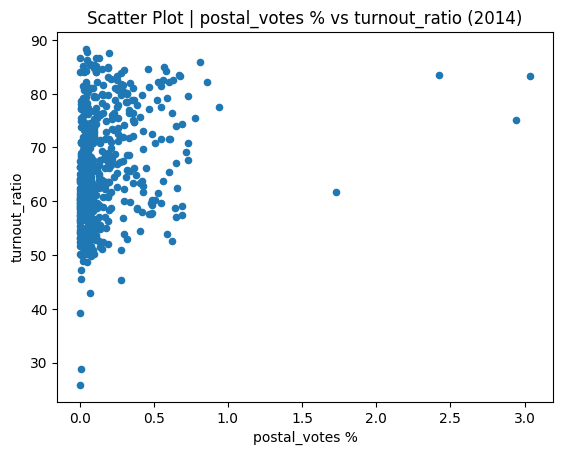

In [55]:
# scatter plot postal_votes vs turnout_ratio 2014 data
df_r14_grouped[["postal_votes %", "turnout_ratio"]].plot(kind="scatter", x="postal_votes %", y="turnout_ratio")
plt.title("Scatter Plot | postal_votes % vs turnout_ratio (2014)")

# Correlation coefficient
print("---------------------")
print("Correlation coeff. between postal_votes % and turnout_ratio:\n", \
      round(df_r14_grouped["postal_votes %"].corr(df_r14_grouped.turnout_ratio), 2))
print("---------------------")

---------------------
Correlation coeff. between postal_votes % and turnout_ratio:
 0.0
---------------------


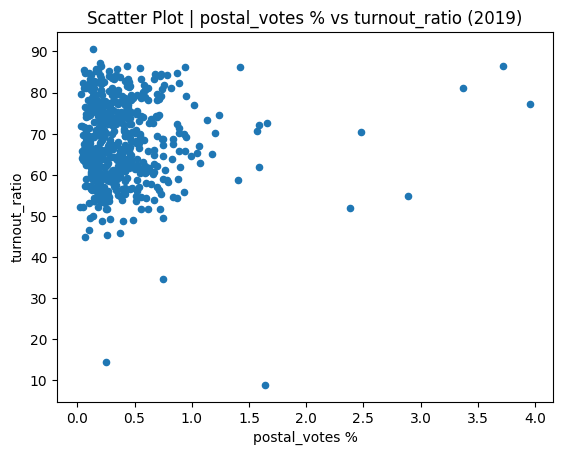

In [56]:
# scatter plot postal_votes vs turnout_ratio 2014 data
df_r19_grouped[["postal_votes %", "turnout_ratio"]].plot(kind="scatter", x="postal_votes %", y="turnout_ratio")
plt.title("Scatter Plot | postal_votes % vs turnout_ratio (2019)")

# Correlation coefficient
print("---------------------")
print("Correlation coeff. between postal_votes % and turnout_ratio:\n", \
      round(df_r19_grouped["postal_votes %"].corr(df_r19_grouped.turnout_ratio), 2))
print("---------------------")

🔍 Obesrvations:
- Upon studying above scatter plots and correlation coefficients (avg = 0.115) we find there is weak positive correlation between `postal votes %` and `turnout ratio`

### Q 2. Is there any correlation between GDP of a state and voter turnout %?

- GDP data for the year 18-19 has been taken from [Wikipedia](https://en.wikipedia.org/wiki/List_of_Indian_states_and_union_territories_by_GDP)

In [57]:
# import gdp data
state_gdp = pd.read_csv(r"datasets/state_gdp_1819.csv")

# data cleaning
state_gdp.state = state_gdp.state.apply(lambda x: x.replace("?*", ""))
state_gdp.head()

,state,gdp_1819_rs_mln
0,Jammu & Kashmir,1598590
1,Andaman & Nicobar Islands,90030
2,Mizoram,219120
3,Nagaland,265270
4,Manipur,273880


In [58]:
# aggregate data to calculate state-wise turnout ratio
df_r19_grp = df_r19.groupby(["state", "pc_name"]).agg({"total_votes": 'sum', "total_electors": 'max'}).reset_index()
df_r19_grp = df_r19_grp.groupby("state")["total_votes", "total_electors"].sum().reset_index()
df_r19_grp["turnout_ratio"] = round(df_r19_grp.total_votes*100/df_r19_grp.total_electors, 2)

# merge gdp data with state-wise turnout ratio
df_gdp_and_turnout = pd.merge(state_gdp, df_r19_grp[["state", "turnout_ratio"]], on="state")
df_gdp_and_turnout.head(3)

,state,gdp_1819_rs_mln,turnout_ratio
0,Jammu & Kashmir,1598590,44.84
1,Andaman & Nicobar Islands,90030,65.09
2,Mizoram,219120,63.05


---------------------
Correlation coeff. between GDP 18-19 and turnout_ratio:        -0.28
---------------------


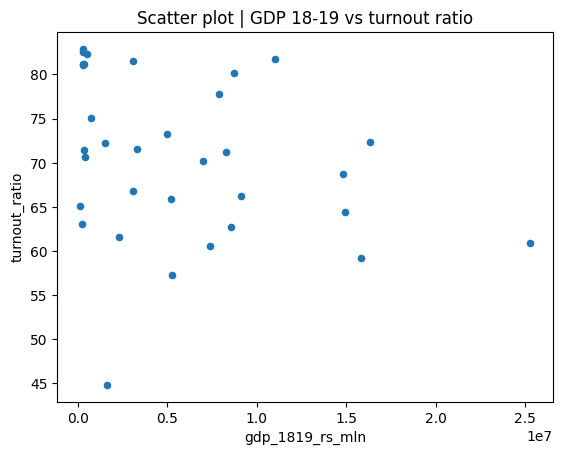

In [59]:
# scatter plot gdp vs turnout ratio
df_gdp_and_turnout.plot(kind="scatter", x="gdp_1819_rs_mln", y="turnout_ratio", xticks=None)
plt.title("Scatter plot | GDP 18-19 vs turnout ratio");

# correlation coefficient
print("---------------------")
print(f"Correlation coeff. between GDP 18-19 and turnout_ratio:\
        {round(df_gdp_and_turnout.gdp_1819_rs_mln.corr(df_gdp_and_turnout.turnout_ratio), 2)}")
print("---------------------")

🔍 Obesrvations:
- We can't strongly infer any relationship from the scatter plot because of less number of data points but the corr coeff comes out to be -0.28 hence we can conclude that there low negative correlation between states GDP and turnout ratio.
- Earlier we have concluded that thinly populated areas like north-eastern states have excellent voter turnout ratio and at the same time if we compare these states have very low gdp contribution, on the other hand state like UP, Maharashtra are higly populated states having maximum contribution to India's gdp have lower turnout ratio. Hence, this negative correlation is corroborated.

### Q 3. Is there any correlation between literacy % of a state and voter turnout %?
- state literacy rates have been taken from [Wikipedia : NSO Survey 2017](https://en.wikipedia.org/wiki/List_of_Indian_states_and_union_territories_by_literacy_rate)

In [60]:
# import litaracy rate data
df_lit_rate = pd.read_csv(r"datasets/literacy_rate.csv")

# merge literacy rate data with state-wise turnout ratio data
df_lit_and_turnout = pd.merge(df_lit_rate, df_r19_grp[["state", "turnout_ratio"]], on="state")
df_lit_and_turnout.head(3)

,state,literacy_rate,turnout_ratio
0,Andaman & Nicobar Islands,86.27,65.09
1,Andhra Pradesh,66.90,80.22
2,Arunachal Pradesh,66.95,81.15


---------------------
Correlation coeff. between Literacy Rate and Turnout Ratio:        0.14
---------------------


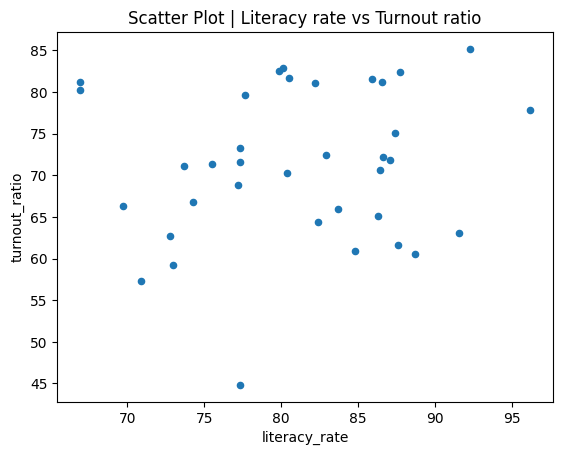

In [61]:
# scatter plot gdp vs turnout ratio
df_lit_and_turnout.plot(kind="scatter", x="literacy_rate", y="turnout_ratio", xticks=None);
plt.title("Scatter Plot | Literacy rate vs Turnout ratio");

# correlation coefficient
print("---------------------")
print(f"Correlation coeff. between Literacy Rate and Turnout Ratio:\
        {round(df_lit_and_turnout.literacy_rate.corr(df_lit_and_turnout.turnout_ratio), 2)}")
print("---------------------")

🔍 Obesrvations:
- Based on above scatter plot and corr coeff value we can infer that there is a weak positive correlation between literacy rate and voter turnout ratio

### Q 4. Provide 3 recommendations on what the election commission/ government 	can do to increase the voter turnout %

#### Here are my top 3 recommendations to the ECI and the GOI:

![recommendations](recommendations.png)

Though voters' educations and awareness is one of the most important ways of positively influencing voters, it is already being a part of ECI's `SVEEP` program, I haven't included it in my top recommendations.